In [19]:
# servers
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# load packages
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import jax
import jax.numpy as jnp
from jax import random
import ml_collections
from ml_collections import config_flags
import tensorflow_datasets as tfds
from absl import logging
import input_pipeline
import matplotlib.pyplot as plt
# import seaborn as sb
import other
import time
# from scipy.stats import normaltest
import classification as cla
# import torch
from importlib import reload
import vae_orthog as vae
import train_vae_withCorthog as train
import utils

# HvdMNIST Data

Load the data. The latent space for each view consists of 20 variables.

In [20]:
no_latents1 = 20
no_latents2 = 20

c_flags1 = other.get_config(no_latents1, no_latents2, number_epochs=30)
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()

logging.info('Initializing dataset.')
train_ds, train_labs = input_pipeline.build_train_set(c_flags1.batch_size, ds_builder,40)
test_ds, test_labs = input_pipeline.build_test_set(ds_builder)
full_train_ds, full_train_labs = input_pipeline.build_full_train(ds_builder)
logging.info('Initializing model.')

The parameters for the classifier.

In [21]:
layer_sizes = [392, 512, 512, 10]
layer_sizes_full = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 30
batch_size = 32
n_targets = 10
params = cla.init_network_params(layer_sizes, random.key(0))
params_full = cla.init_network_params(layer_sizes_full, random.key(0))

# Initial data

The correlation matrix is produced for the full test dataset.

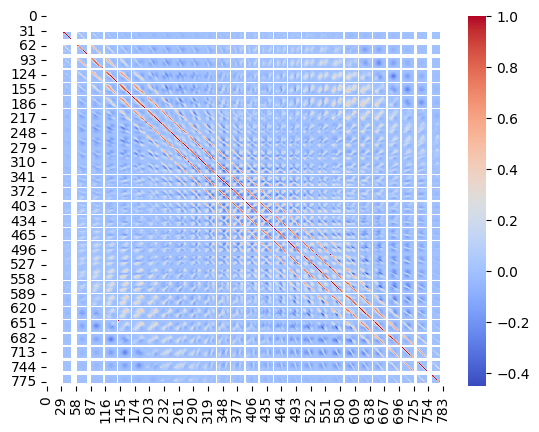

In [5]:
cor = jnp.corrcoef(jnp.transpose(test_ds))
sb.heatmap(cor, cmap='coolwarm')
plt.savefig('figures/corr_v1_v2.png')
plt.show()

And the correlation between views.

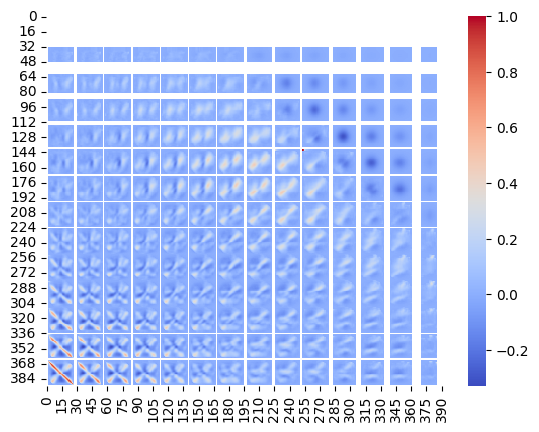

In [6]:
sb.heatmap(cor[0:392,392:784], cmap='coolwarm')
plt.savefig('figures/corr_v1_v2.png')
plt.show()

Classifier is applied on the full dataset - 15 epochs are used here.

In [4]:
logging.info('Initializing dataset.')
train_ds1, train_labs1 = input_pipeline.build_train_set(c_flags1.batch_size, ds_builder,40)
test_ds1, test_labs1 = input_pipeline.build_test_set(ds_builder)
full_train_ds1, full_train_labs1 = input_pipeline.build_full_train(ds_builder)
logging.info('Initializing model.')

2024-10-15 13:01:40.129549: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


View 1

In [5]:
train_res, test_res = cla.class_results(train_ds1, train_labs1,
               test_ds1, test_labs1,
                   full_train_ds1, full_train_labs1, params, num_epochs=15, batch_num=batch_size, cut=0.2)
#print train and test accuracy
print('Train Accuracy: ', train_res[-1])
print('Test Accuracy: ', test_res[-1])

Train Accuracy:  0.96867996
Test Accuracy:  0.93399996


View 2

In [9]:
train_res, test_res = cla.class_results(train_ds1, train_labs1,
               test_ds1, test_labs1,
                   full_train_ds1, full_train_labs1, params, num_epochs=15, batch_num=batch_size, start_range=392, end_range=784)
#print train and test accuracy
print('Train Accuracy: ', train_res[-1])
print('Test Accuracy: ', test_res[-1])


Train Accuracy:  0.94048
Test Accuracy:  0.9091


# C=0

In [3]:
test_zero = train.train_and_eval_split(c_flags1, train_ds, test_ds, full_train_ds, 20000, 30, zero=True)


eval epoch: 5, loss: 93.1902, BCE: 60.5940, KLD: 32.5962, LL: -87.1067
eval epoch: 10, loss: 89.1225, BCE: 55.8876, KLD: 33.2349, LL: -83.3503
eval epoch: 15, loss: 86.8761, BCE: 53.3675, KLD: 33.5086, LL: -81.3796
eval epoch: 20, loss: 86.1480, BCE: 52.8800, KLD: 33.2681, LL: -80.2702
eval epoch: 25, loss: 85.0288, BCE: 51.8133, KLD: 33.2156, LL: -79.3212
eval epoch: 30, loss: 84.1448, BCE: 50.3167, KLD: 33.8281, LL: -78.8926


In [7]:
au1 = sum(jnp.diag(jnp.cov(jnp.transpose(test_zero[0]['mean1'])))>0.01)
au2 = sum(jnp.diag(jnp.cov(jnp.transpose(test_zero[0]['mean2'])))>0.01)
print('Number of active units in latent space 1 is: ', au1)
print('Number of active units in latent space 2 is: ', au2)

Number of active units in latent space 1 is:  12
Number of active units in latent space 2 is:  12


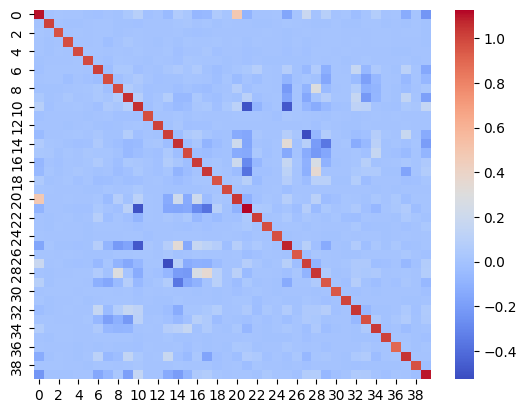

In [13]:
cov1 = other.est_cov(test_zero[0]['z_v1'],test_zero[0]['z_v2'], 40)
sb.heatmap(cov1, cmap='coolwarm')
plt.show()

Classification results trained on the reconstructed data.

In [5]:
result = test_zero
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(result[0]['rec_v1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               result[2]['rec_v1'], result[4]['recon_x1'], test_labs,
                   result[0]['rec_v1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 1')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (result[6][0]))

View 1
Train Accuracy:  0.90287995
Test Accuracy:  0.8908
Decoded Accuracy:  0.47959998
Reconstruction error: 24.411074


In [5]:
result = test_zero
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(result[0]['rec_v1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               result[2]['rec_v1'], result[4]['recon_x1'], test_labs,
                   result[0]['rec_v1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 1')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (result[6][0]))

View 1
Train Accuracy:  0.9026
Test Accuracy:  0.89089996
Decoded Accuracy:  0.4797
Reconstruction error: 24.411074


In [ ]:
result = test_zero
train_data = result[0]['rec_v2']
train_labs = full_train_labs
testing_data = result[2]['rec_v2']
testing_labs = test_labs
recon_data = result[4]['recon_x2']
view = 2

train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(train_data, batch_size), cla.batch_generator(train_labs, batch_size),
               testing_data, recon_data, testing_labs,
                   train_data, full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View ', view)
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (result[6][1]))

In [140]:
result = test_zero
train_data = jnp.concatenate([result[0]['rec_v1'], result[0]['rec_v2']], axis=1)
train_labs = full_train_labs
testing_data = jnp.concatenate([result[2]['rec_v1'],result[4]['recon_x2']], axis=1)
testing_labs = test_labs
recon_data = jnp.concatenate([result[4]['recon_x1'], result[2]['rec_v2']], axis=1)
view = 2
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(train_data, batch_size), cla.batch_generator(train_labs, batch_size),
               testing_data, recon_data, testing_labs,
                   train_data, full_train_labs, params_full, num_epochs=50, batch_num=batch_size,end_range=784)
#print max train and test accuracy
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])

Train Accuracy:  0.9765
Test Accuracy:  0.7898
Decoded Accuracy:  0.7466


Classification results trained on the decoded data.

In [17]:
result = test_zero
train_data = result[3]['recon_x1']
train_labs = full_train_labs
testing_data = result[4]['recon_x1']
testing_labs = test_labs
view = 1

train_acc, test_acc = cla.class_results(cla.batch_generator(train_data, batch_size), cla.batch_generator(full_train_labs, batch_size),
               testing_data, test_labs,
                   train_data, full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View ', view)
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (result[6][1+view]))

View  1
Train Accuracy:  0.78054
Test Accuracy:  0.7744
Reconstruction error: 113.02965


In [18]:
result = test_zero
train_data = result[3]['recon_x2']
train_labs = full_train_labs
testing_data = result[4]['recon_x2']
testing_labs = test_labs
view = 2

train_acc, test_acc = cla.class_results(cla.batch_generator(train_data, batch_size), cla.batch_generator(full_train_labs, batch_size),
               testing_data, test_labs,
                   train_data, full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View ', view)
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (result[6][1+view]))

View  2
Train Accuracy:  0.79807997
Test Accuracy:  0.77379996
Reconstruction error: 129.38197


Produce image reconstruction plots for $C=0$.

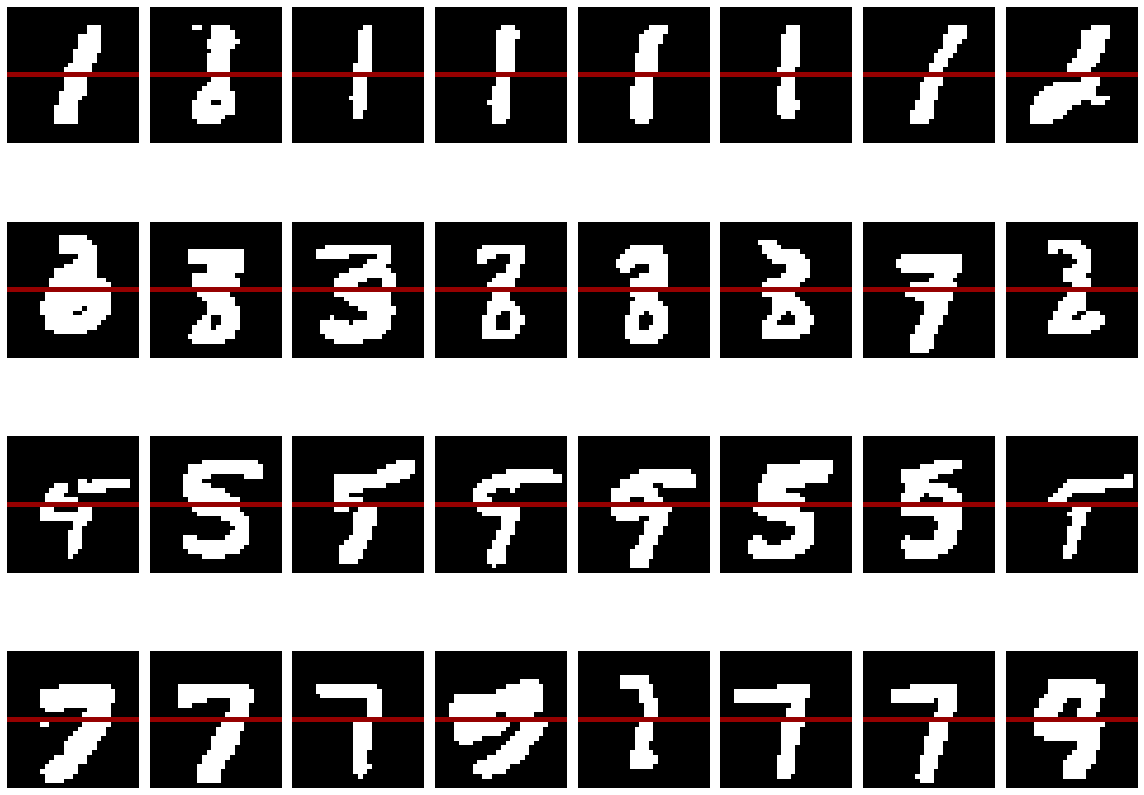

In [40]:
fig = utils.plot_images(test_ds, test_labs, test_zero, key=14, digits= list(jnp.array([1,3,5,7])),save_image=True, filename="figures/images_noC_sub.png", sub=True)

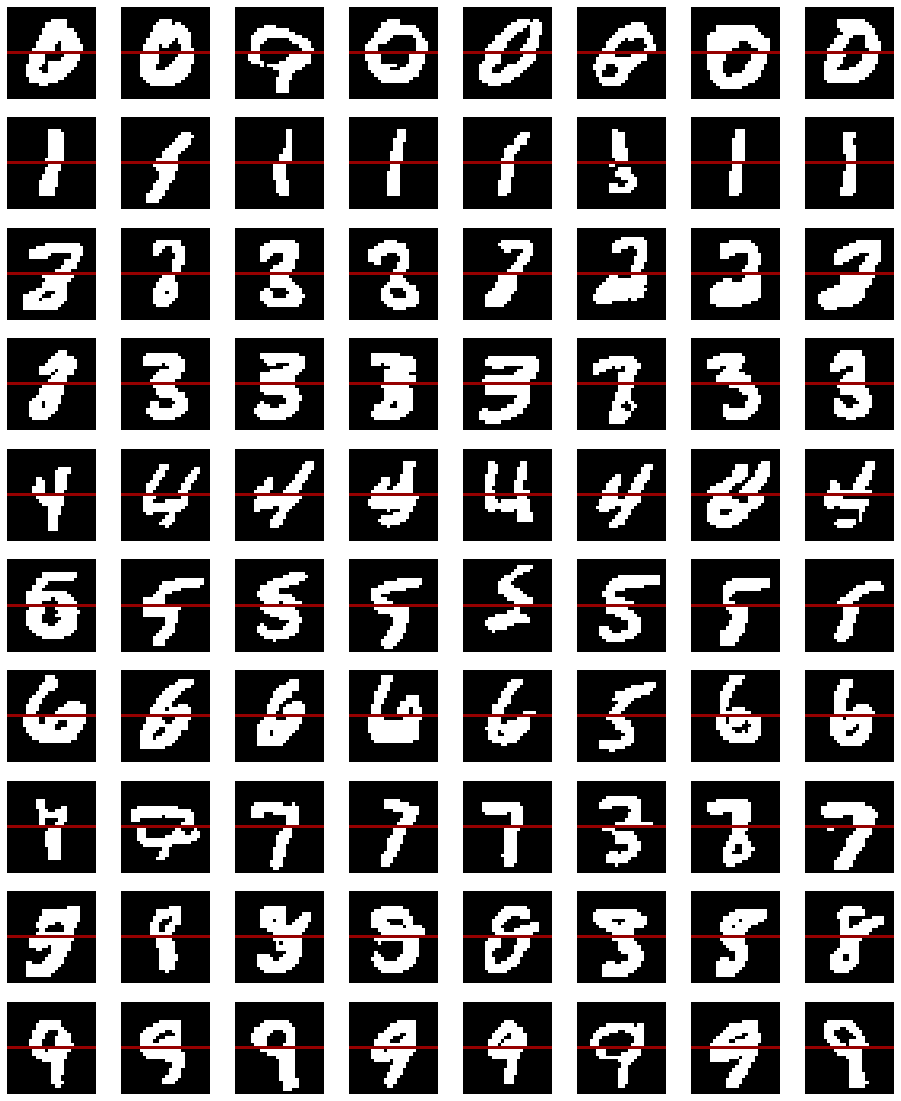

In [39]:
figs = utils.plot_images(test_ds, test_labs, test_zero, key=50, save_image=True, filename="figures/images_noC1.png")

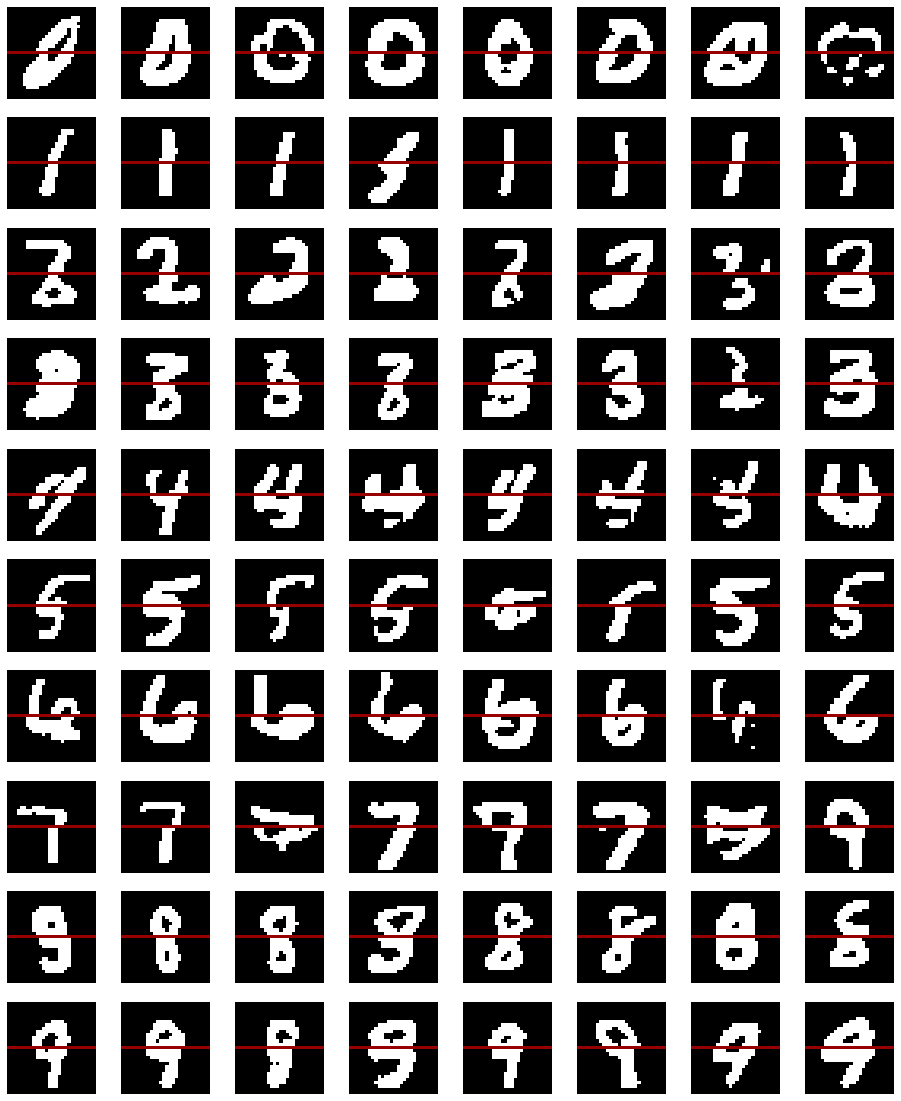

In [38]:
figs2 = utils.plot_images(test_ds, test_labs, test_zero, key=51, save_image=True, filename="figures/images_noC2.png")

In [13]:
reload(utils)

<module 'utils' from '/home/icnfs/ma/e/eso18/multi_view_vae/utils.py'>

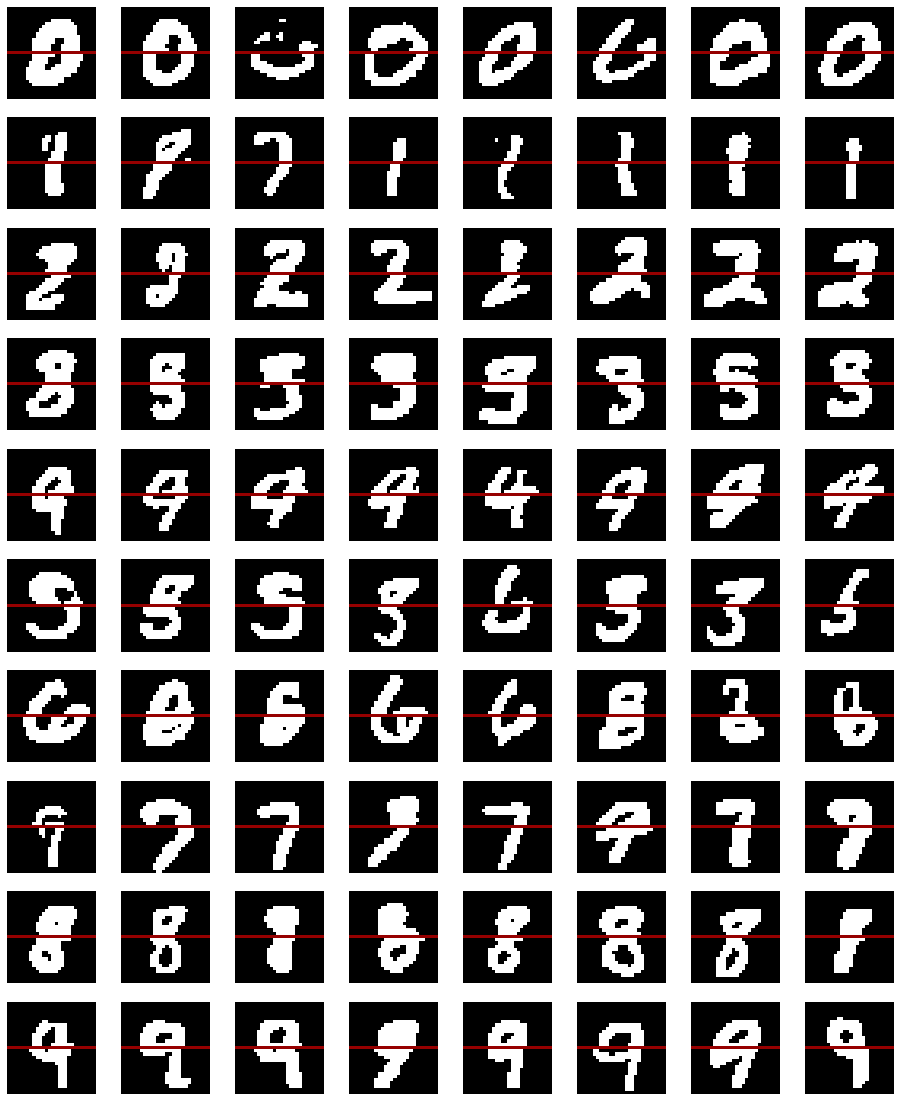

In [37]:
figs_bottom = utils.plot_images(test_ds, test_labs, test_zero, key=50, save_image=True,v2_impute=False, filename="figures/images_noC_v1.png")

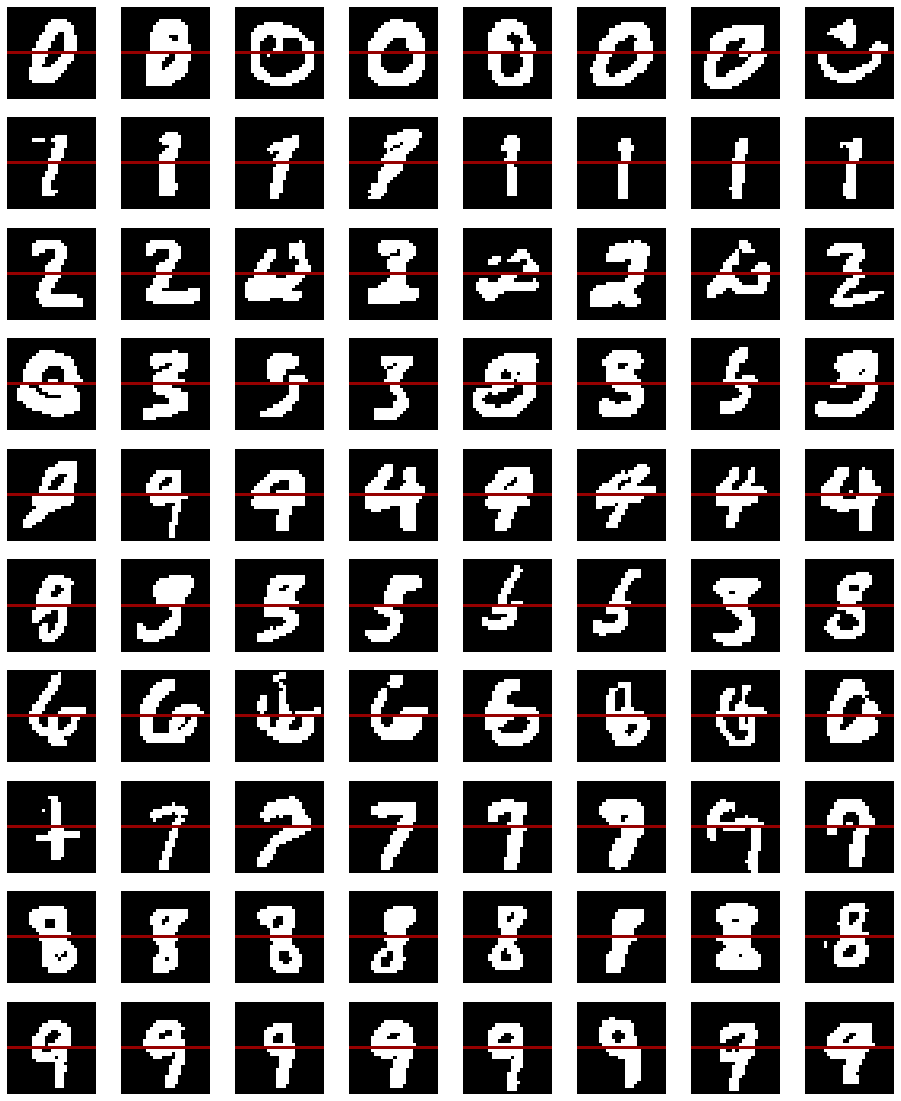

In [36]:
figs2_bottom = utils.plot_images(test_ds, test_labs, test_zero, key=51, save_image=True,v2_impute=False, filename="figures/images_noC_v1_2.png")

In [16]:
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs2[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs_bottom[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs2_bottom[2].mean())

Average binary cross entropy loss between bottom half of image and reconstruction is:  109.048645
Average binary cross entropy loss between bottom half of image and reconstruction is:  117.82503
Average binary cross entropy loss between bottom half of image and reconstruction is:  111.93093
Average binary cross entropy loss between bottom half of image and reconstruction is:  114.34094


# Orthogonality constraints


##Cayley parametrization

In [17]:
test_orthog_param = train.train_and_eval_split(c_flags1, train_ds, test_ds, full_train_ds, 20000, 30)


eval epoch: 5, loss: 100.9654, BCE: 56.5267, KLD: 44.4387, LL: -95.1466
eval epoch: 10, loss: 97.2304, BCE: 53.6368, KLD: 43.5936, LL: -90.7464
eval epoch: 15, loss: 94.3496, BCE: 50.6794, KLD: 43.6701, LL: -88.3605
eval epoch: 20, loss: 93.1666, BCE: 48.6348, KLD: 44.5318, LL: -87.7478
eval epoch: 25, loss: 92.8712, BCE: 48.8836, KLD: 43.9876, LL: -87.0750
eval epoch: 30, loss: 91.8133, BCE: 47.6175, KLD: 44.1958, LL: -86.2983


### Correlation plots


NameError: name 'sns' is not defined

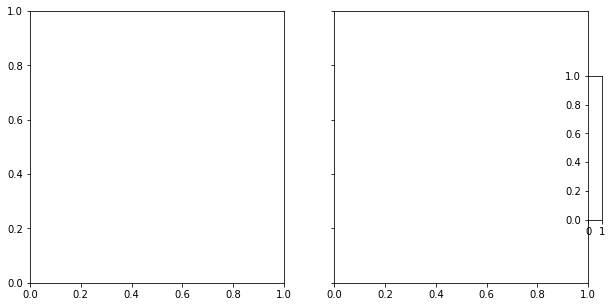

In [18]:
cor1 = jnp.corrcoef(jnp.transpose(jnp.concatenate((test_orthog_param[0]['z_v1'],test_orthog_param[0]['z_v2']), axis=1)))
cor2 = jnp.corrcoef(jnp.transpose(jnp.concatenate((test_zero[0]['z_v1'],test_zero[0]['z_v2']), axis=1)))

# Set up a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.8, 0.8]})
cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4])

# Find the global min and max for both datasets to normalize the color scale
vmin = min(cor1.min(), cor2.min())
vmax = max(cor1.max(), cor2.max())

# Create the first heatmap
sb.heatmap(cor2, ax=ax1, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('C=0')

# Create the second heatmap
sb.heatmap(cor1, ax=ax2, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=True,cbar_ax=cbar_ax)
ax2.set_title('Learnt C')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/cor_comparison.png')
plt.show()


<ipython-input-10-bf5bf5ac4a53>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


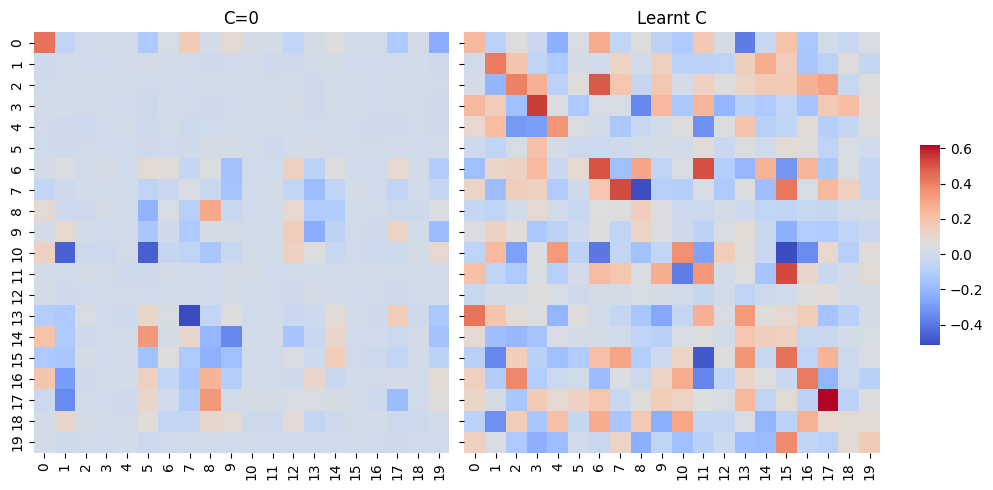

In [10]:
c_cor1 = jnp.corrcoef(jnp.transpose(jnp.concatenate((test_orthog_param[0]['z_v1'],test_orthog_param[0]['z_v2']), axis=1)))[0:20,20:40]
c_cor2 = jnp.corrcoef(jnp.transpose(jnp.concatenate((test_zero[0]['z_v1'],test_zero[0]['z_v2']), axis=1)))[0:20,20:40]

# Set up a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.8, 0.8]})
cbar_ax = fig.add_axes([0.925, 0.3, 0.02, 0.4])

# Find the global min and max for both datasets to normalize the color scale
vmin = min(c_cor1.min(), c_cor2.min())
vmax = max(c_cor1.max(), c_cor2.max())

# Create the first heatmap
sns.heatmap(c_cor2, ax=ax1, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('C=0')

# Create the second heatmap
sns.heatmap(c_cor1, ax=ax2, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=True,cbar_ax=cbar_ax)
ax2.set_title('Learnt C')


plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/cross_cor_comparison.png')
plt.show()


In [11]:
print('C=0 estimated cross-correlation matrix has norm ',jnp.sqrt(jnp.square(c_cor2).sum()))
print('Learnt C estimated cross-correlation matrix has norm ',jnp.sqrt(jnp.square(c_cor1).sum()))
print('C=0 estimated correlation matrix has norm ',jnp.sqrt(jnp.square(cor2).sum()))
print('Learnt C estimated correlation matrix has norm ',jnp.sqrt(jnp.square(cor1).sum()))

C=0 estimated cross-correlation matrix has norm  1.7164714
Learnt C estimated cross-correlation matrix has norm  3.4266043
C=0 estimated correlation matrix has norm  6.808289
Learnt C estimated correlation matrix has norm  8.4334955


<ipython-input-26-30c3a1999ccf>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


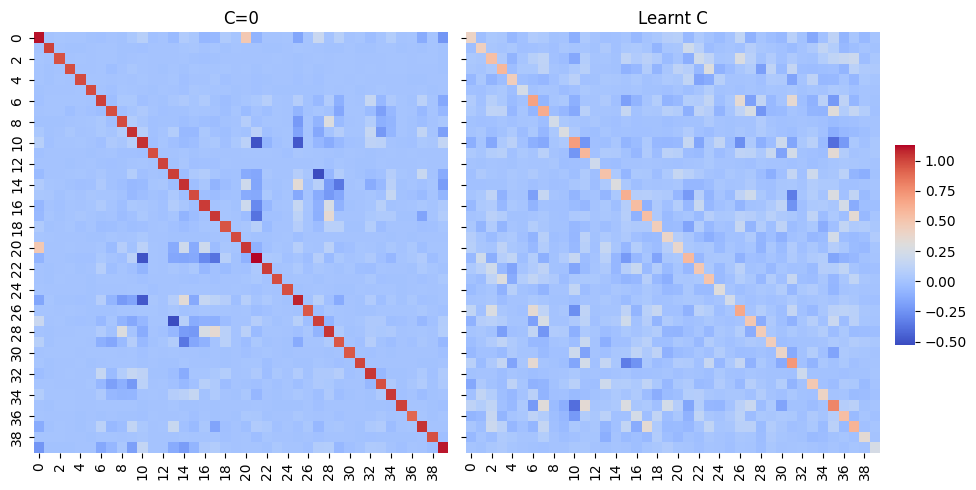

In [26]:
# cov1 = other.est_cov(test_orthog_param[0]['z_v1'],test_orthog_param[0]['z_v2'],40)[0:20,20:40]
# cov2 = other.est_cov(test_zero[0]['z_v1'],test_zero[0]['z_v2'],40)[0:20,20:40]
cov1 = other.est_cov(test_orthog_param[0]['z_v1'],test_orthog_param[0]['z_v2'],40)
cov2 = other.est_cov(test_zero[0]['z_v1'],test_zero[0]['z_v2'],40)
# Set up a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.8, 0.8]})
cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4])

# Find the global min and max for both datasets to normalize the color scale
vmin = min(cov1.min(), cov2.min())
vmax = max(cov1.max(), cov2.max())

# Create the first heatmap
sns.heatmap(cov2, ax=ax1, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('C=0')

# Create the second heatmap
sns.heatmap(cov1, ax=ax2, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=True,cbar_ax=cbar_ax)
ax2.set_title('Learnt C')

plt.savefig('figures/cov_comparison.png')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


<ipython-input-27-49c9a5b86db1>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


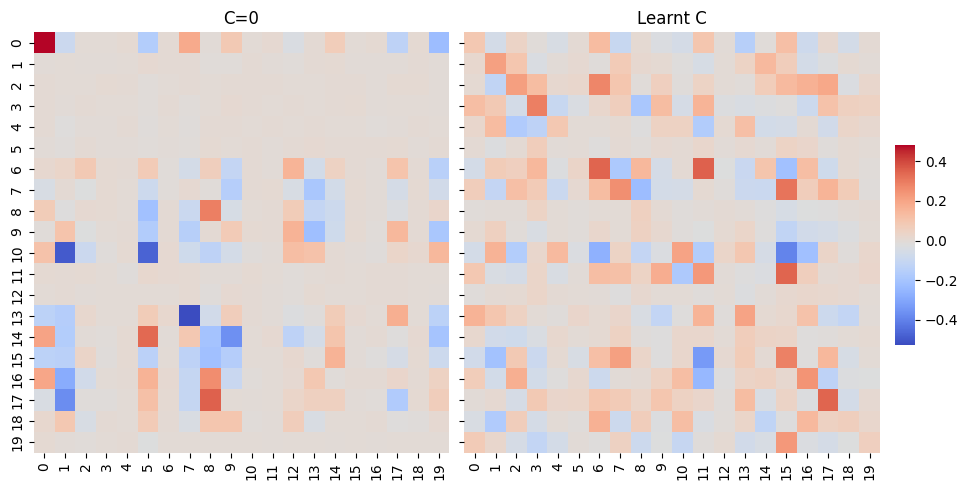

In [27]:
c_cov1 = other.est_cov(test_orthog_param[0]['z_v1'],test_orthog_param[0]['z_v2'],40)[0:20,20:40]
c_cov2 = other.est_cov(test_zero[0]['z_v1'],test_zero[0]['z_v2'],40)[0:20,20:40]
# Set up a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.8, 0.8]})
cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.4])

# Find the global min and max for both datasets to normalize the color scale
vmin = min(c_cov1.min(), c_cov2.min())
vmax = max(c_cov1.max(), c_cov2.max())

# Create the first heatmap
sns.heatmap(c_cov2, ax=ax1, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('C=0')

# Create the second heatmap
sns.heatmap(c_cov1, ax=ax2, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=True,cbar_ax=cbar_ax)
ax2.set_title('Learnt C')

plt.savefig('figures/cross_cov_comparison.png')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [13]:
print('C=0 estimated cross-correlation matrix has norm ',jnp.sqrt(jnp.square(c_cor2).sum()))
print('Learnt C estimated cross-correlation matrix has norm ',jnp.sqrt(jnp.square(c_cor1).sum()))
print('C=0 estimated correlation matrix has norm ',jnp.sqrt(jnp.square(cor2).sum()))
print('Learnt C estimated correlation matrix has norm ',jnp.sqrt(jnp.square(cor1).sum()))

C=0 estimated cross-correlation matrix has norm  1.7164714
Learnt C estimated cross-correlation matrix has norm  3.4266043
C=0 estimated correlation matrix has norm  6.808289
Learnt C estimated correlation matrix has norm  8.4334955


In [16]:
au1 = sum(jnp.diag(jnp.cov(jnp.transpose(test_orthog_param[0]['mean1'])))>0.01)
au2 = sum(jnp.diag(jnp.cov(jnp.transpose(test_orthog_param[0]['mean2'])))>0.01)
print('Number of active units in latent space 1 is: ', au1)
print('Number of active units in latent space 2 is: ', au2)

Number of active units in latent space 1 is:  20
Number of active units in latent space 2 is:  20


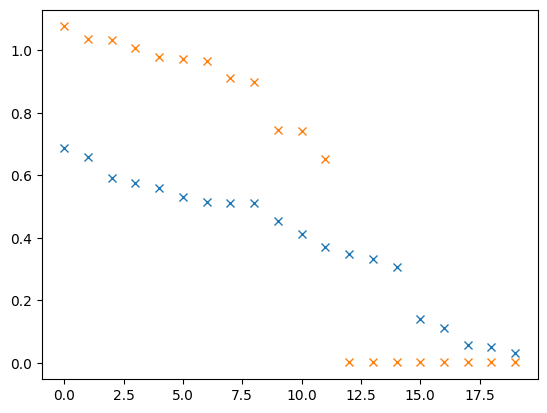

In [30]:
plt.plot(jnp.sort(jnp.diag(jnp.cov(jnp.transpose(test_orthog_param[0]['mean1']))))[::-1],'x')
plt.plot(jnp.sort(jnp.diag(jnp.cov(jnp.transpose(test_zero[0]['mean1']))))[::-1],'x')
plt.show()

### Image reconstruction plots


In [31]:
reload(utils)

<module 'utils' from '/home/icnfs/ma/e/eso18/multi_view_vae/utils.py'>

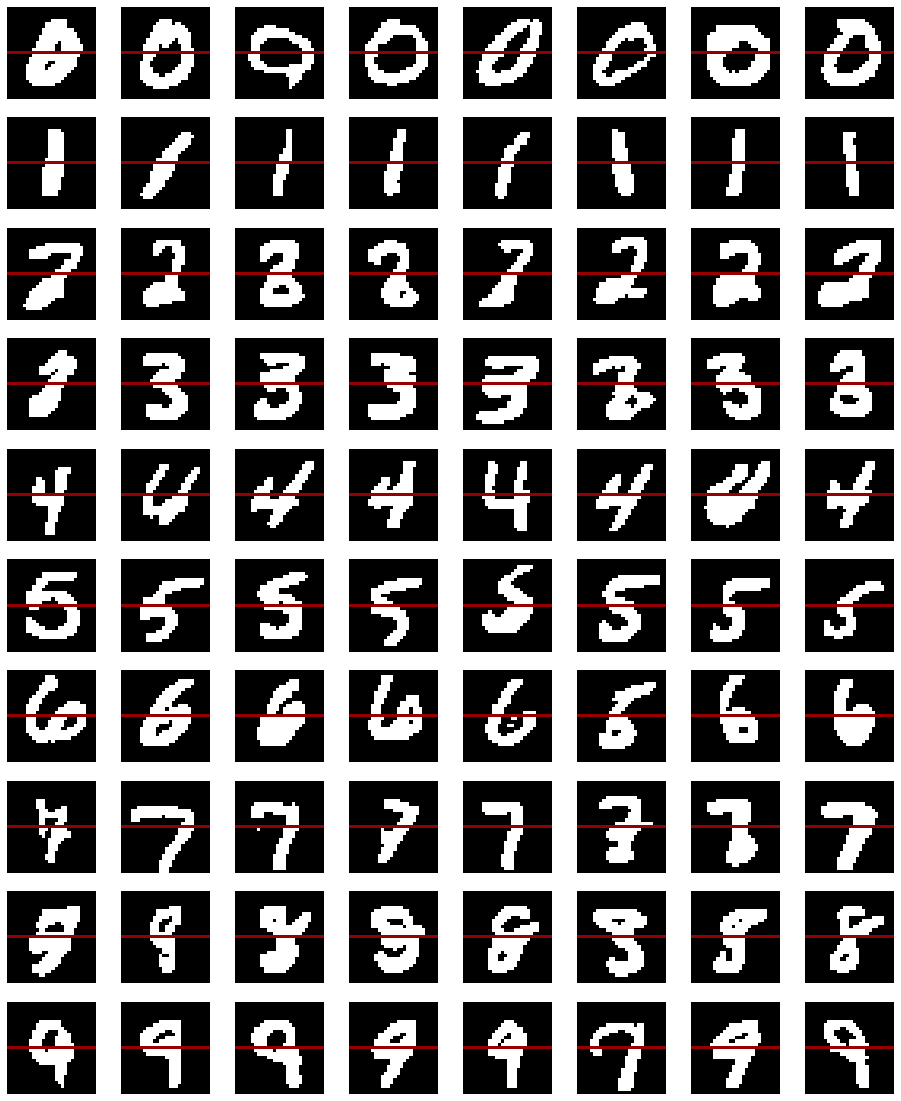

In [32]:
figs = utils.plot_images(test_ds, test_labs, test_orthog_param, key=50, save_image=True, filename="figures/images_C1.png")

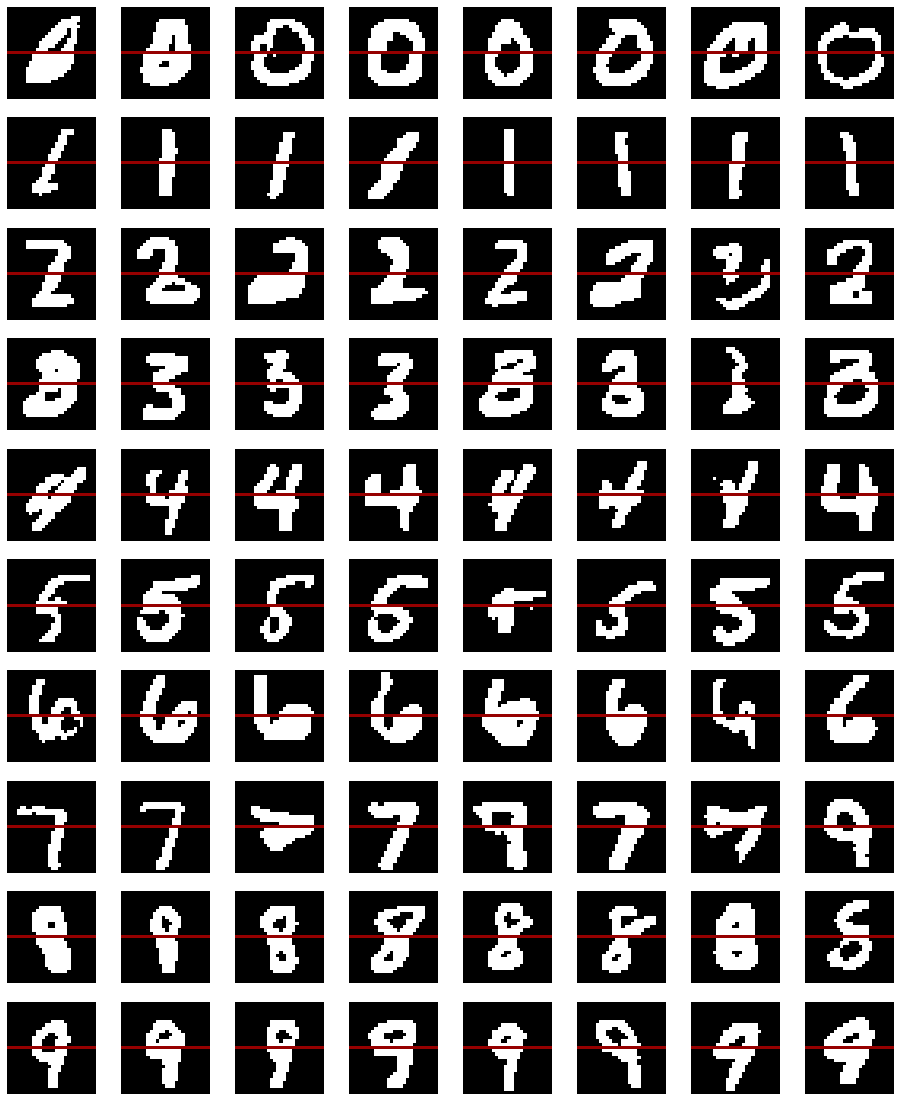

In [33]:
figs2 = utils.plot_images(test_ds, test_labs, test_orthog_param, key=51, save_image=True, filename="figures/images_C2.png")

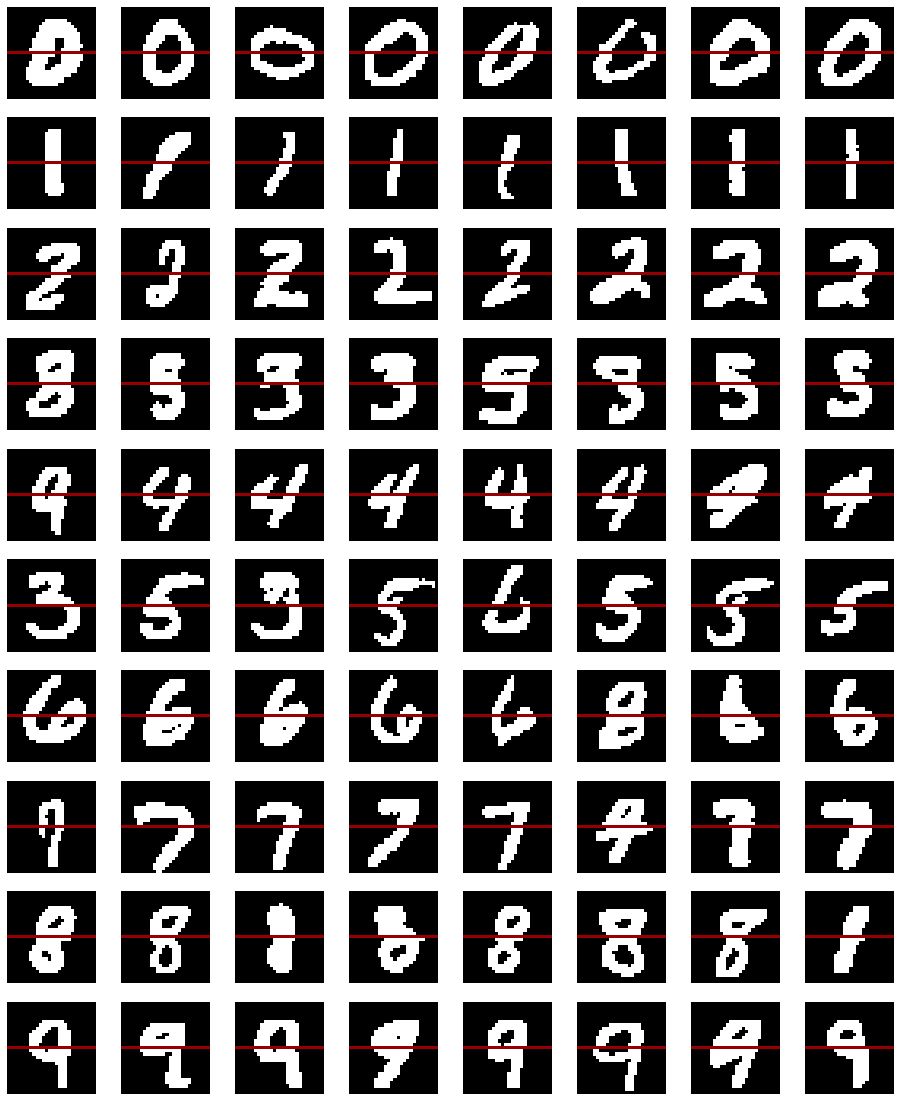

In [34]:
figs_bottom = utils.plot_images(test_ds, test_labs, test_orthog_param, key=50, save_image=True, v2_impute=False, filename="figures/images_C_imputev1.png")

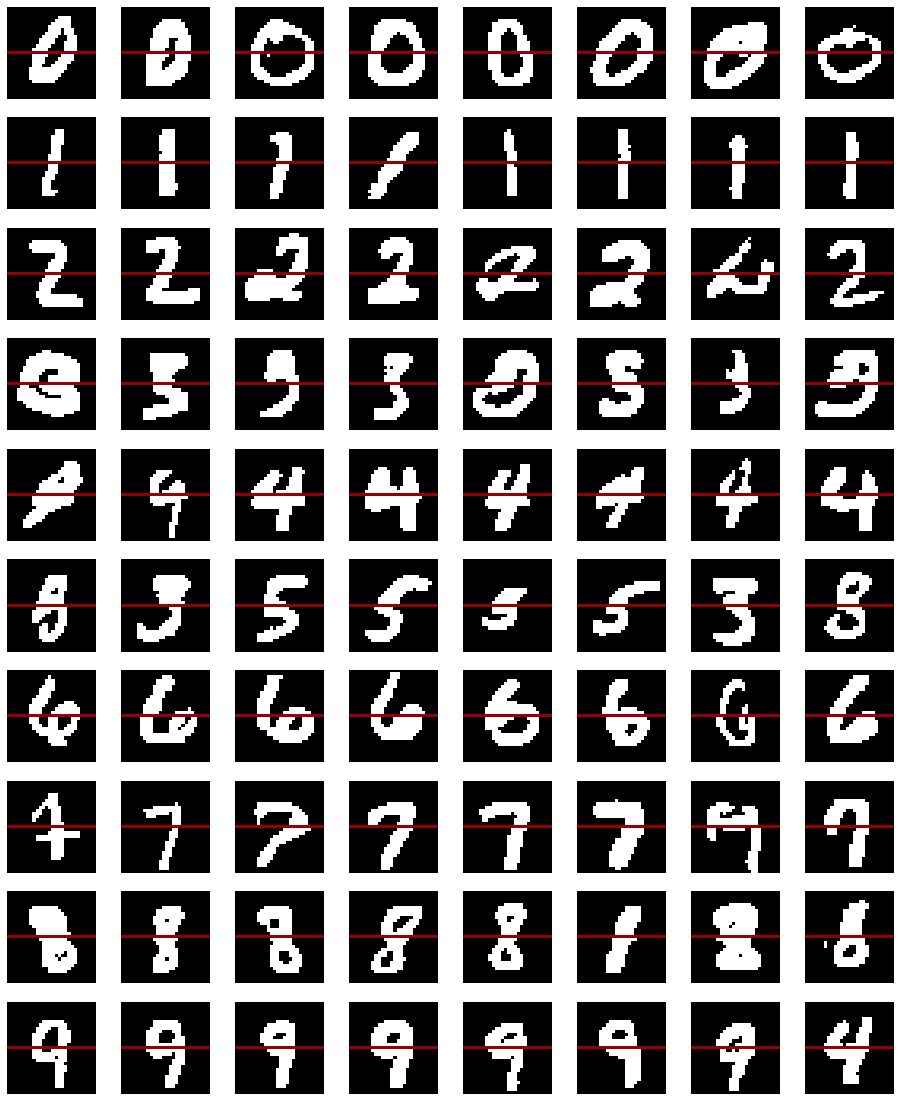

In [35]:
figs2_bottom = utils.plot_images(test_ds, test_labs, test_orthog_param, key=51, save_image=True, v2_impute=False, filename="figures/images_C_imputev1_2.png")

In [26]:
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs2[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs_bottom[2].mean())
print('Average binary cross entropy loss between bottom half of image and reconstruction is: ', figs2_bottom[2].mean())


Average binary cross entropy loss between bottom half of image and reconstruction is:  93.04421
Average binary cross entropy loss between bottom half of image and reconstruction is:  101.54631
Average binary cross entropy loss between bottom half of image and reconstruction is:  100.206505
Average binary cross entropy loss between bottom half of image and reconstruction is:  104.11653


### Classification results

View 1

In [7]:
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(test_orthog_param[0]['rec_v1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_orthog_param[2]['rec_v1'], test_orthog_param[4]['recon_x1'], test_labs,
                   test_orthog_param[0]['rec_v1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 1')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (test_orthog_param[6][0]))

View 1
Train Accuracy:  0.91757995
Test Accuracy:  0.9076
Decoded Accuracy:  0.796
Reconstruction error: 23.523922


View 2

In [34]:
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(test_orthog_param[0]['rec_v2'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_orthog_param[2]['rec_v2'], test_orthog_param[4]['recon_x2'], test_labs,
                   test_orthog_param[0]['rec_v2'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 2')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (test_orthog_param[6][1]))

View 2
Train Accuracy:  0.87975997
Test Accuracy:  0.87119997
Decoded Accuracy:  0.7707
Reconstruction error: 24.509192


In [142]:
result = test_orthog_param
train_data = jnp.concatenate([result[0]['rec_v1'], result[0]['rec_v2']], axis=1)
train_labs = full_train_labs
testing_data = jnp.concatenate([result[2]['rec_v1'],result[4]['recon_x2']], axis=1)
testing_labs = test_labs
recon_data = jnp.concatenate([result[4]['recon_x1'], result[2]['rec_v2']], axis=1)
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(train_data, batch_size), cla.batch_generator(train_labs, batch_size),
               testing_data, recon_data, testing_labs,
                   train_data, full_train_labs, params_full, num_epochs=50, batch_num=batch_size,end_range=784)
#print max train and test accuracy
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])

Train Accuracy:  0.97653997
Test Accuracy:  0.8734
Decoded Accuracy:  0.8411


And the following from the cross prediction for view 1:

In [8]:
train_acc, test_acc = cla.class_results(cla.batch_generator(test_orthog_param[3]['recon_x1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_orthog_param[4]['recon_x1'], test_labs,
                   test_orthog_param[3]['recon_x1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View 1')
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (test_orthog_param[6][2]))

View 1
Train Accuracy:  0.84951997
Test Accuracy:  0.8419
Reconstruction error: 98.758286


And view 2:

In [9]:
train_acc, test_acc = cla.class_results(cla.batch_generator(test_orthog_param[3]['recon_x2'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_orthog_param[4]['recon_x2'], test_labs,
                   test_orthog_param[3]['recon_x2'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View 2')
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (test_orthog_param[6][3]))

View 2
Train Accuracy:  0.88659996
Test Accuracy:  0.87509996
Reconstruction error: 112.31276


# Eigenvalue constraints


In [15]:
import train_vae_withCevals as train_evals

In [14]:
reload(train_evals)

<module 'train_vae_withCevals' from '/content/drive/MyDrive/multi_view_vae/train_vae_withCevals.py'>

##Cayley parametrization




In [17]:
test_evals_param = train_evals.train_and_eval_split(c_flags1, train_ds, test_ds, full_train_ds, 20000, 30)


eval epoch: 5, loss: 91.4935, BCE: 59.2062, KLD: 32.2873, LL: -85.6150
eval epoch: 10, loss: 86.7494, BCE: 53.6035, KLD: 33.1459, LL: -81.2621
eval epoch: 15, loss: 85.0271, BCE: 51.5499, KLD: 33.4772, LL: -79.7096
eval epoch: 20, loss: 84.2146, BCE: 50.8021, KLD: 33.4125, LL: -78.6099
eval epoch: 25, loss: 83.5657, BCE: 50.0731, KLD: 33.4926, LL: -78.0754
eval epoch: 30, loss: 82.6638, BCE: 48.4266, KLD: 34.2372, LL: -77.6395


View 1

In [39]:
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(test_evals_param[0]['rec_v1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_evals_param[2]['rec_v1'], test_evals_param[4]['recon_x1'], test_labs,
                   test_evals_param[0]['rec_v1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 1')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (test_evals_param[6][0]))

View 1
Train Accuracy:  0.90726
Test Accuracy:  0.8964
Decoded Accuracy:  0.6315
Reconstruction error: 24.34529


View 2

In [40]:
train_acc_, test_acc_, recon_acc_ = cla.class_results_all(cla.batch_generator(test_evals_param[0]['rec_v2'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_evals_param[2]['rec_v2'], test_evals_param[4]['recon_x2'], test_labs,
                   test_evals_param[0]['rec_v2'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
#print max train and test accuracy
print('View 2')
print('Train Accuracy: ', train_acc_[-1])
print('Test Accuracy: ', test_acc_[-1])
print('Decoded Accuracy: ',recon_acc_[-1])
print('Reconstruction error:', (test_evals_param[6][1]))

View 2
Train Accuracy:  0.87399995
Test Accuracy:  0.86609995
Decoded Accuracy:  0.6658
Reconstruction error: 24.706017


And the following from the cross prediction for view 1:

In [41]:
train_acc, test_acc = cla.class_results(cla.batch_generator(test_evals_param[3]['recon_x1'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_evals_param[4]['recon_x1'], test_labs,
                   test_evals_param[3]['recon_x1'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View 1')
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (test_evals_param[6][2]))

View 1
Train Accuracy:  0.81035995
Test Accuracy:  0.8053
Reconstruction error: 109.6334


And view 2:

In [42]:
train_acc, test_acc = cla.class_results(cla.batch_generator(test_evals_param[3]['recon_x2'], batch_size), cla.batch_generator(full_train_labs, batch_size),
               test_evals_param[4]['recon_x2'], test_labs,
                   test_evals_param[3]['recon_x2'], full_train_labs, params, num_epochs=50, batch_num=batch_size)
print('View 2')
print('Train Accuracy: ', train_acc[-1])
print('Test Accuracy: ', test_acc[-1])
print('Reconstruction error:', (test_evals_param[6][3]))

View 2
Train Accuracy:  0.84308
Test Accuracy:  0.8315
Reconstruction error: 121.04492


In [18]:
au1 = sum(jnp.diag(jnp.cov(jnp.transpose(test_evals_param[0]['mean1'])))>0.01)
au2 = sum(jnp.diag(jnp.cov(jnp.transpose(test_evals_param[0]['mean2'])))>0.01)
print('Number of active units in latent space 1 is: ', au1)
print('Number of active units in latent space 2 is: ', au2)

Number of active units in latent space 1 is:  13
Number of active units in latent space 2 is:  14
